# Universal Gap function for use with L01, CU SIM and L2D 
## Overall goal

The overall goal here is to provide a simple and easy to use code that generates a masking function mimicking our best understanding of missing data with respect to LISA. 

## What does the code do? 

The code takes in a dictionary of planned and unplanned gaps with their specific types, rates per year and duration in hours. It can then produce a binary mask

\begin{equation}
 w(t) = 1 \ \text{if} \ t \not \in T_{\text{gap}} \  \text{and} \  w(t) = \boldsymbol{\text{nan}} \  \text{if} \  t \in T_{\text{gap}}\,.
 \end{equation}

In [7]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from lisaglitch import GapMaskGenerator
from lisaconstants import TROPICALYEAR_J2000DAY



Usable data
Duty cyle is = 90.5473681205097 %


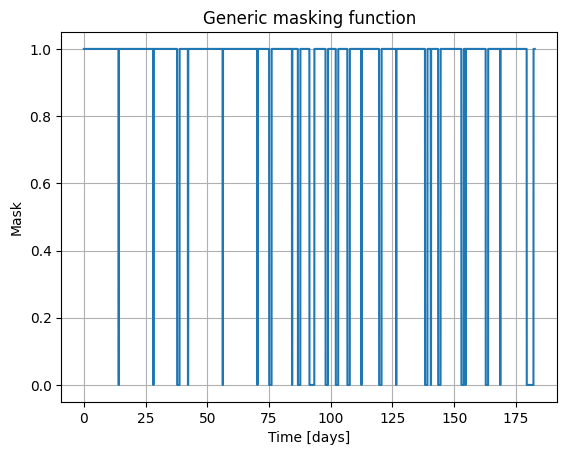

In [8]:

# Set up simulation properties
A_YEAR = TROPICALYEAR_J2000DAY * 86400  # seconds in a year
dt = 0.25  # seconds
t_start = 0 # start time in seconds
t_obs = 0.5*A_YEAR
sim_t = t_start + np.arange(0,t_obs, dt) # time array

planseed = 2618240388
unplanseed = 3387490715

# Build dictionary of gap definitions, planned and unplanned. We must 
# supply both of these, even if the rates are zero and durations are zero. 
# We can cope with arbitrary number of gaps.
gap_definitions = {
    "planned": {
        "antenna repointing": {"rate_per_year": 26, "duration_hr": 3.3},
        "TM stray potential": {"rate_per_year": 2, "duration_hr": 24},
        "TTL calibration": {"rate_per_year": 4, "duration_hr": 48},
        #"Aliens": {"rate_per_year": 6, "duration_hr": 30*24}
    },
    "unplanned": {
        "platform safe mode": {"rate_per_year": 3, "duration_hr": 60},
        "payload safe mode": {"rate_per_year": 4, "duration_hr": 66},
        "QPD loss micrometeoroid": {"rate_per_year": 5, "duration_hr": 24},
        "HR GRS loss micrometeoroid": {"rate_per_year": 19, "duration_hr": 24},
        "WR GRS loss micrometeoroid": {"rate_per_year": 6, "duration_hr": 24},
    }
}

# Initialise the class with simulation properties and whether or not to treat gaps with
# nans or not. 
gap_mask_gen = GapMaskGenerator(sim_t, 
                                gap_definitions, 
                                treat_as_nan = False, 
                                planseed = planseed,
                                unplanseed = unplanseed)

# Generate the mask as a np.array. Choose whether to include unplanned and/or planned gaps.
# num_zeros = np.sum(full_mask == 0)/len(full_mask)
full_mask = gap_mask_gen.generate_mask(include_unplanned=True, include_planned=True)
num_zeros = np.sum(full_mask == 0)/len(full_mask)
print("Usable data")
print(f"Duty cyle is = {100*(1-num_zeros)} %")

plt.plot(sim_t/60/60/24,full_mask)
plt.xlabel(r'Time [days]')
plt.ylabel(r'Mask')
plt.title(r'Generic masking function')
plt.grid()

## Some extra utilities

It is possible to save the masking function as a `.h5` file. Similarly, we can load the `.h5` file as a class object and generate the masking function.  

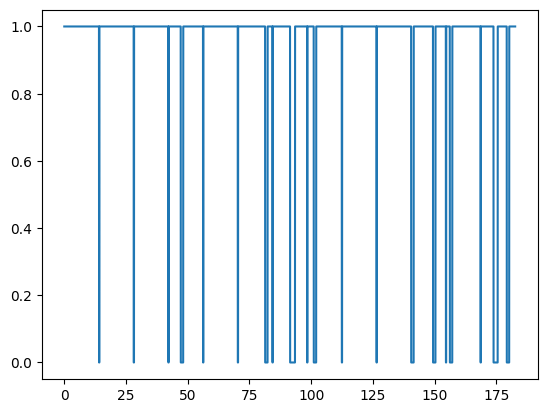

In [9]:
# Save the masking function to a hdf5 file. 
gap_mask_gen.save_to_hdf5(full_mask, filename = "gap_mask_data.h5")

# Load the masking function to a hdf5 file. Note that we do not need to instantiate the class. 
# This will load in the masking function and all important attributes. 
load_gating_func = GapMaskGenerator.from_hdf5(filename = "gap_mask_data.h5")
plt.plot(sim_t/60/60/24, load_gating_func.generate_mask(include_unplanned=True, include_planned=True))

## Generate summary of gap configuration

We can easily generate a summary of the gap configuration using one of the functions in the class method. 

In [10]:
check = gap_mask_gen.summary(mask = full_mask, export_json_path="gap_mask_summary.json")
from pprint import pprint
pprint(check)

{'mask_analysis': {'duty_cycle_percent': np.float64(90.5474),
                   'number_of_gap_segments': 24,
                   'total_gap_hours': np.float64(414.3),
                   'total_gap_samples': 5965920},
 'planned_gaps': {'TM stray potential': {'duration_hr': 24,
                                         'duration_samples': 345600,
                                         'duration_sec': 86400,
                                         'rate_events_per_sec': 6.33775307356206e-08,
                                         'rate_events_per_year': 2},
                  'TTL calibration': {'duration_hr': 48,
                                      'duration_samples': 691200,
                                      'duration_sec': 172800,
                                      'rate_events_per_sec': 1.267550614712412e-07,
                                      'rate_events_per_year': 4},
                  'antenna repointing': {'duration_hr': 3.3,
                                      

# Smooth tapers

So far the gap function generates a binary mask with eithers zeros or *nans* representing the gaps. For those within L2D, it may be preferable to smoothly taper the gap segments to zeros in order to reduce artefacts working in the frequency or time-frequency domains. 

To facilitate this, we have taken the binary mask and applied a smooth taper on either side of each gap with the "length of the lobes" provided as input. An example is given below 

In [11]:

from lisagap import GapWindowGenerator

from lisagap import GapWindowGenerator
masking_func_from_window = GapWindowGenerator(gap_mask_gen) 

In [12]:
# Define the length of the tapering window on each side of the gap. Must input lobe lengths in hours. 

# If we miss out a particular gap definition, it will not be tapered. 

taper_defs = {
    "planned": {
        "antenna repointing": {"lobe_lengths_hr": 5.0},
        "TM stray potential": {"lobe_lengths_hr": 0.5},
        "TTL calibration": {"lobe_lengths_hr": 2.0}},
        # "Aliens": {"lobe_lengths_hr" : 1 * 24}},
    "unplanned": {
        "platform safe mode": {"lobe_lengths_hr": 1.0},
        "HR GRS loss micrometeoroid": {"lobe_lengths_hr": 0.25},
        "QPD loss micrometeoroid": {"lobe_lengths_hr":1.0},
        "HR GRS loss micrometeoroid": {"lobe_lengths_hr":7.0},
        "WR GRS loss micrometeoroid": {"lobe_lengths_hr":10.0}
    }
}

smoothed_mask = masking_func_from_window.generate_window(include_planned=True, 
                                                         include_unplanned=True, 
                                                         apply_tapering=True, 
                                                         taper_definitions=taper_defs)

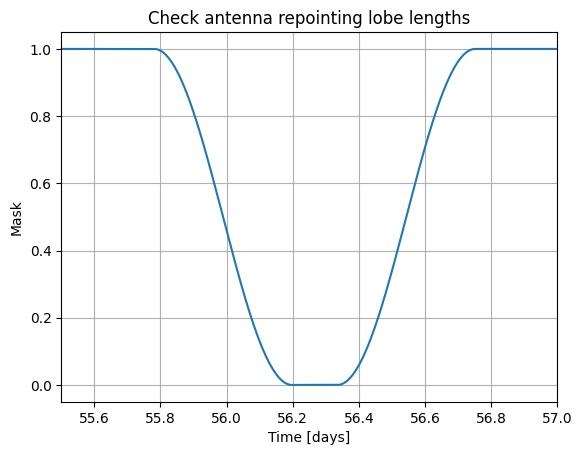

In [13]:
plt.plot(sim_t/60/60/24,smoothed_mask)
plt.xlim([55.5,57])
plt.xlabel(r'Time [days]')
plt.ylabel(r'Mask')
plt.title(r'Check antenna repointing lobe lengths')
plt.grid()


# Build quality masking data set with flags 

We can also use this class to build a masking function based off the nature of a data set. If a np.array is fed into a particular functino of the class, it can be read in and a further array with 1s for valid data and nans for invalid data can be produced

Duty cycle =  90.54736812050972 %


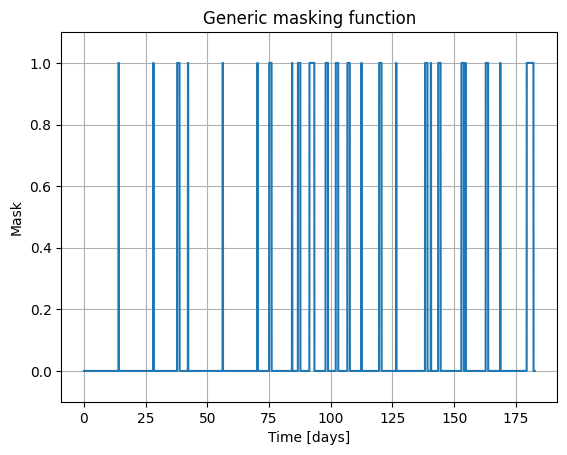

In [14]:
gap_mask_gen_w_nans = GapMaskGenerator(sim_t, 
                                       gap_definitions, 
                                       planseed = 2618240388,
                                       unplanseed = 3387490715,
                                       treat_as_nan = True)

# Generate the mask as a np.array. Choose whether to include unplanned and/or planned gaps.
full_mask_w_nans = gap_mask_gen_w_nans.generate_mask(include_unplanned=True, include_planned=True)


# Build the quality flags. 
quality_flags = gap_mask_gen.build_quality_flags(full_mask_w_nans)
plt.plot(sim_t/60/60/24,quality_flags)
plt.ylim([-0.1,1.1])
plt.xlabel(r'Time [days]')
plt.ylabel(r'Mask')
plt.title(r'Generic masking function')
plt.grid()
# Check, what is the overall duty cycle?

duty_cycle = 100*(len(quality_flags) - np.sum(quality_flags))/len(quality_flags)
print("Duty cycle = ", duty_cycle, "%")


# Proportional Tapering for External Gap Masks

The new `apply_proportional_tapering` static method allows you to apply smart tapering to gap masks loaded from external files (like `.npy` arrays). This is particularly useful when you have gap masks from other sources and want to apply proportional tapering based on gap duration.

## Key Features:
- **Automatic gap detection**: Finds both NaN and zero-valued gaps
- **Smart categorization**: Different taper fractions for short, medium, and long gaps
- **Proportional tapering**: Taper length scales with gap duration (e.g., 5% of gap length)
- **Tukey window**: Uses optimal α calculation for smooth transitions

In [ ]:
build_masking_func = GapMaskGenerator.quality_flags_to_mask(quality_flags)

In [90]:
# Apply proportional tapering using the static method
print("Applying proportional tapering...")

# Standard proportional tapering (5% each side for medium/long gaps)
tapered_standard = GapWindowGenerator.apply_proportional_tapering(
    build_masking_func,
    dt=dt,
    short_taper_fraction= 0.25,   # 25% each side for short gaps
    medium_taper_fraction=0.25,  # 25% each side for medium gaps
    long_taper_fraction=0.25,    # 5% each side for long gaps
    short_gap_threshold_minutes=10,  # Gaps < 15 min are "short"
    long_gap_threshold_hours=2       # Gaps > 1 hour are "long"
)


Applying proportional tapering...


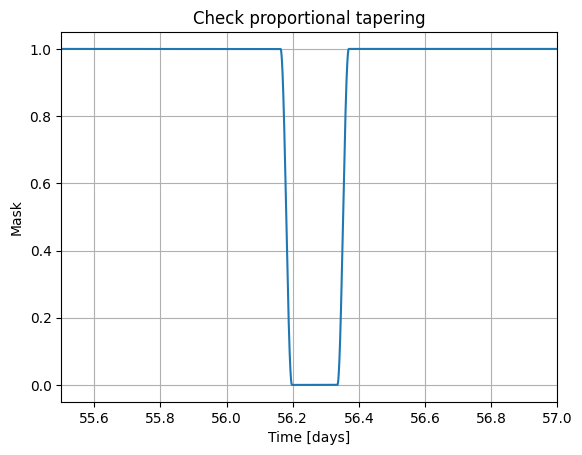

In [91]:
plt.plot(sim_t/60/60/24,tapered_standard)
plt.xlim([55.5,57])
plt.xlabel(r'Time [days]')
plt.ylabel(r'Mask')
plt.title(r'Check proportional tapering')
plt.grid()

## Data Segmentation Approach

Instead of tapering gaps, we can also segment the data into continuous chunks and analyze them separately. This is useful when you want to:

- Analyze each continuous segment independently
- Preserve the original data without modification
- Combine results from multiple segments later

The `DataSegmentGenerator` class provides this functionality.

In [92]:
# Import the DataSegmentGenerator
from lisagap import DataSegmentGenerator

# Create some sample data with gaps
sample_data = np.sin(2 * np.pi * 0.01 * sim_t) + 0.1 * np.random.randn(len(sim_t))

# Use the existing tapered mask from cell 16
# This shows how segmentation works with already-tapered data
window_mask = tapered_standard

# Create the DataSegmentGenerator
segmenter = DataSegmentGenerator(
    mask=window_mask,
    data=sample_data, 
    dt=dt,
    t0=0.0
)

# Get summary information
summary = segmenter.summary()
print("Segmentation Summary:")
print(f"Total segments found: {summary['total_segments']}")
print(f"Data fraction valid: {summary['data_fraction_valid']:.2%}")
print(f"Segment lengths: {summary['segment_lengths']}")
print(f"Mean segment length: {summary['mean_segment_length']:.1f} samples")

Segmentation Summary:
Total segments found: 25
Data fraction valid: 90.55%
Segment lengths: [np.int64(4855779), np.int64(4808941), np.int64(3289397), np.int64(1165753), np.int64(4813858), np.int64(4805812), np.int64(1608962), np.int64(2848885), np.int64(781604), np.int64(1268631), np.int64(1565011), np.int64(1086348), np.int64(1274629), np.int64(1612772), np.int64(2438510), np.int64(2030581), np.int64(4001351), np.int64(456478), np.int64(989817), np.int64(2906778), np.int64(222014), np.int64(2787712), np.int64(1675510), np.int64(3672845), np.int64(179953)]
Mean segment length: 2285917.2 samples


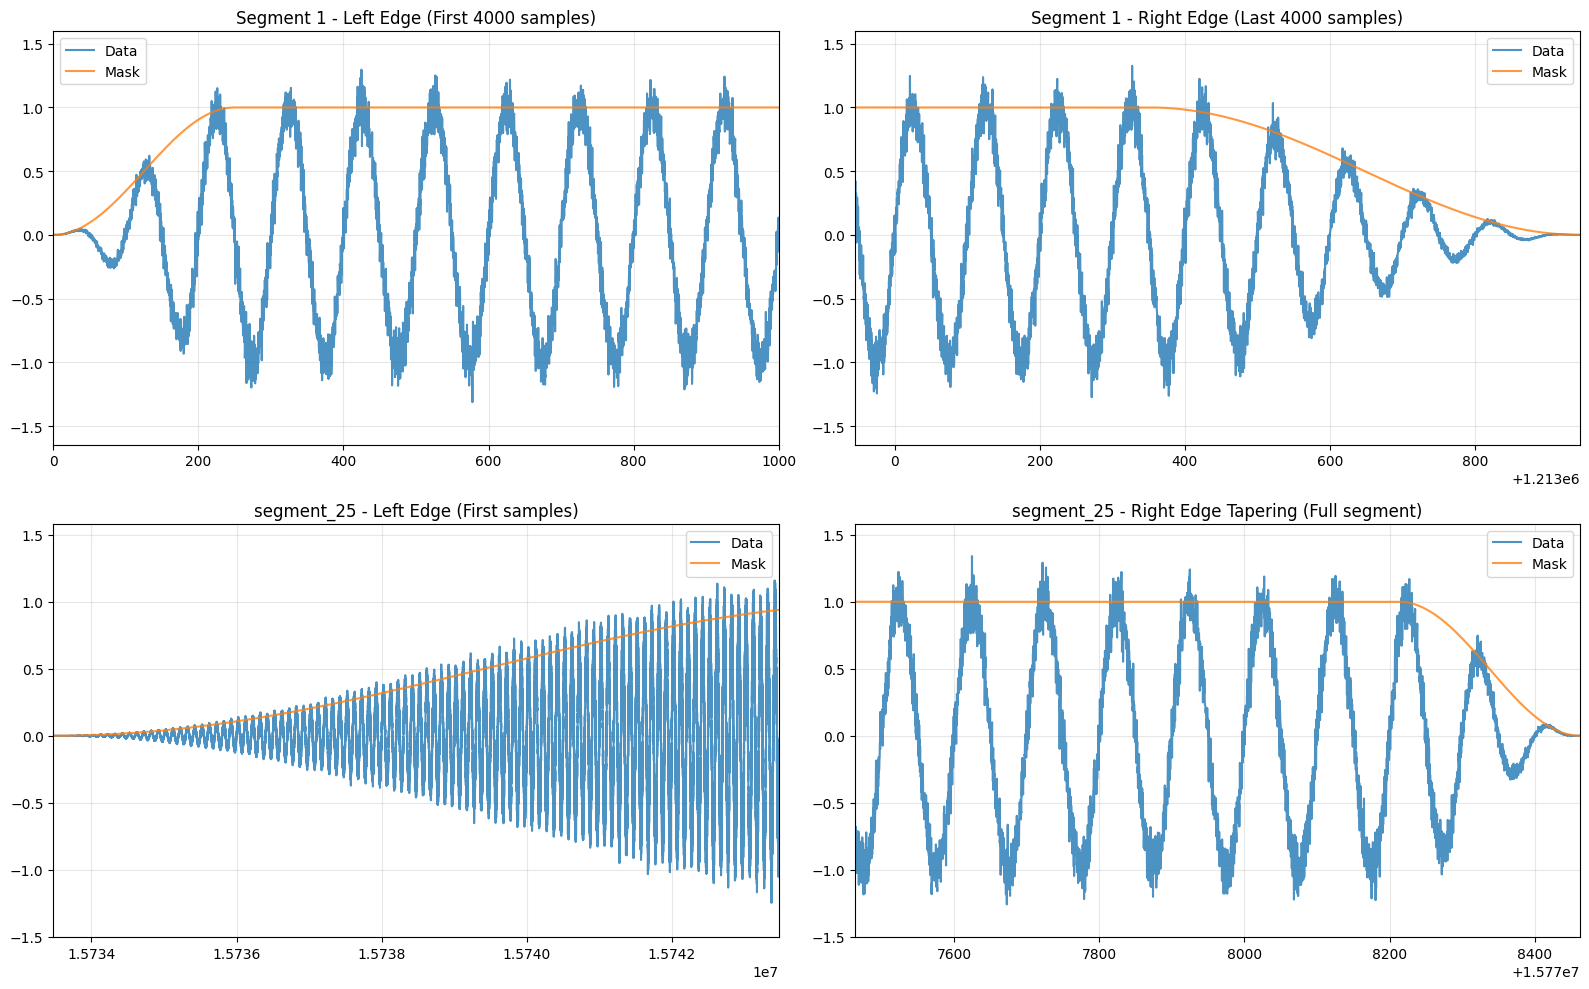

In [ ]:
time_segments = segmenter.get_time_segments(apply_window=True, left_edge_taper = 1000, right_edge_taper = 1000)
# Plot segment 1 data
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot segment 1 data and mask (top left)
axes[0,0].plot(time_segments['segment_1']['time'], time_segments['segment_1']['data'], label='Data', alpha=0.8)
axes[0,0].plot(time_segments['segment_1']['time'], time_segments['segment_1']['mask'], label='Mask', alpha=0.8)
axes[0,0].set_xlim([time_segments['segment_1']['time'][0], time_segments['segment_1']['time'][4000]])
axes[0,0].set_title('Segment 1 - Left Edge (First 4000 samples)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot segment 1 data and mask (top right) - last 4000 samples
axes[0,1].plot(time_segments['segment_1']['time'], time_segments['segment_1']['data'], label='Data', alpha=0.8)
axes[0,1].plot(time_segments['segment_1']['time'], time_segments['segment_1']['mask'], label='Mask', alpha=0.8)
axes[0,1].set_xlim([time_segments['segment_1']['time'][-4000], time_segments['segment_1']['time'][-1]])
axes[0,1].set_title('Segment 1 - Right Edge (Last 4000 samples)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot last segment data and mask (bottom left) - first 4000 samples
last_seg_key = 'segment_25'
axes[1,0].plot(time_segments[last_seg_key]['time'], time_segments[last_seg_key]['data'], label='Data', alpha=0.8)
axes[1,0].plot(time_segments[last_seg_key]['time'], time_segments[last_seg_key]['mask'], label='Mask', alpha=0.8)
axes[1,0].set_xlim([time_segments[last_seg_key]['time'][0], time_segments[last_seg_key]['time'][min(40000, len(time_segments[last_seg_key]['time'])-1)]])
axes[1,0].set_title(f'{last_seg_key} - Left Edge (First samples)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot last segment data and mask (bottom right) - last samples showing right tapering
axes[1,1].plot(time_segments[last_seg_key]['time'], time_segments[last_seg_key]['data'], label='Data', alpha=0.8)
axes[1,1].plot(time_segments[last_seg_key]['time'], time_segments[last_seg_key]['mask'], label='Mask', alpha=0.8)
# Show all samples since segment 25 is relatively short
axes[1,1].set_xlim([time_segments[last_seg_key]['time'][-4000], time_segments[last_seg_key]['time'][-1]])
axes[1,1].set_title(f'{last_seg_key} - Right Edge Tapering (Full segment)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()

# Set x-axis limits to show the last 1000 points of segment 1

plt.show()

In [101]:
# Demonstrate frequency domain analysis of segments
freq_info = segmenter.get_freq_info_from_segments()

/Users/ollie.burke/Documents/Work/Code/lisagap/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


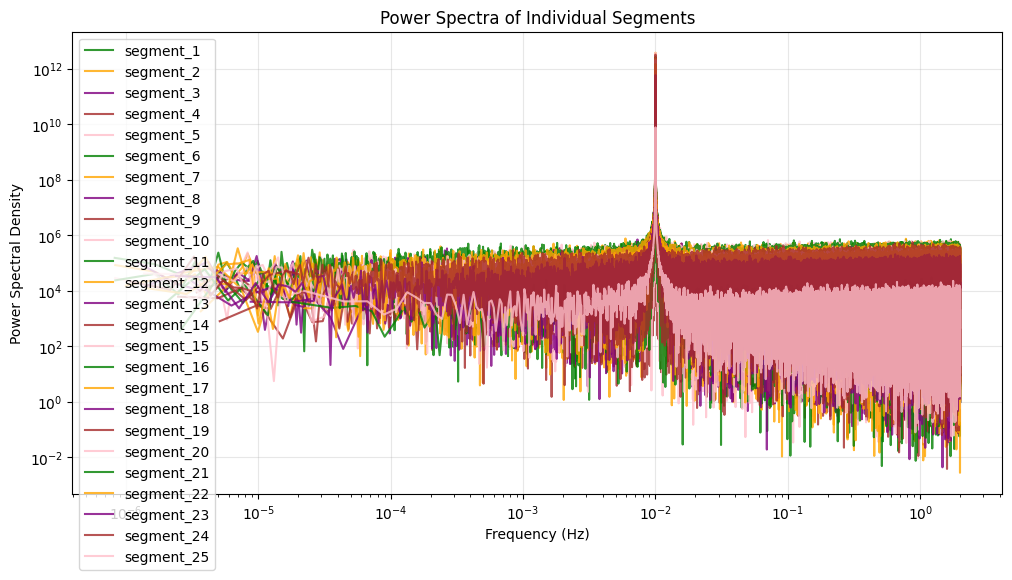

Frequency analysis completed for each segment separately!


In [ ]:
plt.figure(figsize=(12, 6))

for i, (seg_name, seg_freq) in enumerate(freq_info.items()):
    color = colors[i % len(colors)]
    
    # Plot power spectral density
    psd = np.abs(seg_freq['fft'])**2
    plt.loglog(seg_freq['frequencies'][1:], psd[1:], 
               color=color, label=f'{seg_name}', alpha=0.8)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Power Spectra of Individual Segments')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Frequency analysis completed for each segment separately!")

### Integration with GapWindowGenerator

You can also create a `DataSegmentGenerator` directly from a `GapWindowGenerator`, which returns both the segmenter and the mask for downstream reuse:

In [ ]:
# Example of integrated workflow
new_segmenter, reusable_mask = DataSegmentGenerator.from_gap_generator(
    gap_window_generator=window_generator,
    data=sample_data,
    dt=dt,
    t0=0.0,
    apply_tapering=False  # No tapering for clean segmentation
)

print("Created DataSegmentGenerator from GapWindowGenerator")
print(f"Mask shape: {reusable_mask.shape}")
print(f"Mask can be reused for other operations!")

# Show that we get the same results
new_summary = new_segmenter.summary()
print(f"Same number of segments: {new_summary['total_segments']}")
print(f"Same valid data fraction: {new_summary['data_fraction_valid']:.2%}")

# Enhanced Segmentation with Edge Tapering

The `DataSegmentGenerator` now supports advanced windowing and edge tapering to prevent artifacts at segment boundaries. This is particularly useful for frequency domain analysis where boundary discontinuities can cause spectral leakage.